In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import csv
import pickle 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [3]:
#open a df from loop 

#in this example, we add glycogenes to the LN model
with open('master_df_glycogene_countdown_TILs_split_df.pkl', 'rb') as f:
   master_df = pickle.load(f)


In [4]:
#set up dataframe for making plot, but first ensure row number is a multiple of three, representing testing 
#three models

fullgene_array = [0.853453, 0.847187, 0.850158]  # gene array varies by experiment
df_fig = pd.DataFrame()
df_fig["auc_roc"] = master_df.groupby(master_df.index // 3)['roc_auc'].apply(lambda x: list(x)).reset_index(drop=True)


df_fig["pval"] = pd.Series(dtype=float)
for i in range(215):
    row = i
    temp_array = list(df_fig.loc[i, "auc_roc"])
    stat, pval = stats.ttest_rel(temp_array, fullgene_array)
    #stat, pval = stats.ttest_ind(temp_array, fullgene_array, alternative = 'less')
    df_fig.loc[i, "pval"] = pval
    
df_fig["stan_dev"] = pd.Series(dtype=float)
for i in range(215):
    row = i
    temp_array = list(df_fig.loc[i, "auc_roc"])
    std = np.std(temp_array)
    df_fig.loc[i, "stan_dev"] = std

df_fig["mean"] = pd.Series(dtype=float)
for i in range(215):
    row = i
    temp_array = list(df_fig.loc[i, "auc_roc"])
    mean = np.mean(temp_array)
    df_fig.loc[i, "mean"] = mean


/tmp/ipykernel_3422/2608877000.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('cool')
/tmp/ipykernel_3422/2608877000.py:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


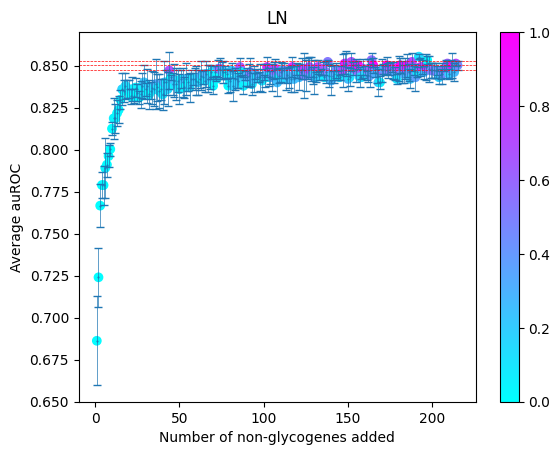

In [6]:
#plot auROCs for genes added 

my_list = list(range(1, 216)) #this corresponds to counting the genes added, depends on experiment

fig, ax = plt.subplots()

x = my_list
y = df_fig['mean'].values
err = df_fig['stan_dev'].values
plt.ylim(0.65, 0.87)

plt.errorbar(x, y, fmt='o', yerr = err, capsize=3, markersize=0.5, linewidth=0.5)
plt.xlabel('Number of non-glycogenes added')
plt.ylabel('Average auROC')


# Set up a colormap that maps p-values to colors
cmap = plt.cm.get_cmap('cool')
normalize = plt.Normalize(vmin=0, vmax=1)
colors = [cmap(normalize(value)) for value in df_fig['pval'].values]

# Create the scatter plot with colored points
plt.scatter(x, y, c=colors)

# Add a colorbar legend to the plot
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])
plt.colorbar(sm)


#plotting line of averaged auROC from three full transcriptome models
plt.axhline(y= np.mean(fullgene_array), color='r', linestyle='--', linewidth=0.5) 

plt.axhline(y= np.std(fullgene_array)+ np.mean(fullgene_array), color='r', linestyle='--', linewidth=0.5) 

plt.axhline(y= np.mean(fullgene_array) - np.std(fullgene_array), color='r', linestyle='--', linewidth=0.5) 

plt.title('LN')

plt.savefig('change in auROC values by adding nonglycogenes LN.pdf', dpi=300, bbox_inches='tight')

plt.show()